In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<div class="markdown-google-sans">

## File Handling

</div>

In [ ]:
import os
import shutil

dir = "/content/drive/MyDrive/gan_datasets/cyclegan"
destination_dir = os.path.join(dir, "0_real")

for files in os.listdir(dir):
    if files != "0_real" and files != "1_fake":
        for filename in os.listdir(os.path.join(dir, files, "0_real")):
            source_path = os.path.join(dir, files, "0_real", filename)
            destination_path = os.path.join(destination_dir, f"{files}_{filename}")
            shutil.copy(source_path, destination_path)

print("All files copied.")

All files copied.


<div class="markdown-google-sans">

## Cloning github repo for importing openai's clip model
</div>

In [ ]:
# !conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

<div class="markdown-google-sans">

## Checking for pytorch version dependencies and cuda(both ok on google collab gpu)
</div>


In [3]:
import torch

print("Torch version:", torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# image = Image.open("/content/drive/MyDrive/gan_datasets/biggan/0_real/0--n01440764_5043.png")


Torch version: 2.1.0+cu121
cuda


<div class="markdown-google-sans">

## Importing the clip model from the github repo cloned above
</div>



In [ ]:
import clip

model, preprocess = clip.load("ViT-L/14")
model.cuda()

<div class="markdown-google-sans">

## Checking functions inside inbuilt preprocess function of clip model
</div>


In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7c934a74aa70>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

## The architecture used below
*  Loaded images from Progan dataset for training
*  Feeded them into clip ViT/L-14 model to extract features
* Similiarly extracted features for test dataset
## Now we implement two methods
1.   **Cosine Similiarity**-Measured cosine distance between test and nearest real and fake feature, and classified it as a real or fake image depending on which is the nearest neighbour.
2.   **Linear Classification**- Added a FCNN layer for simple binary classification using binary cross entropy loss with sigmoid activation function with batch size 30 and 7 epochs.








<div class="markdown-google-sans">

## Defining custom augmentation and extract feature functions
</div>


In [6]:
from PIL import Image,ImageFilter
import numpy as np
import torchvision.transforms as transforms
import os

def custom_augmentation(image_path):
    image = Image.open(image_path)

    if np.random.rand() < 0.5:
        image = image.filter(ImageFilter.GaussianBlur(radius=2)) #radius=std deviation
    img_path = 't.jpg'
    image.save(img_path, format='JPEG', quality=80)
    image = Image.open(img_path)
    os.remove(img_path)
    return image

def extract_features(image_input):
    with torch.no_grad(): #because we are performing inference(extracting feature representation) so we dont need gradient for backprogagation
        image_features = model.encode_image(image_input)
    return image_features

<div class="markdown-google-sans">

## Extracting features from the real and fake image datasets
</div>


In [7]:
real_image_path = "/content/drive/MyDrive/gan_datasets/progan/0_real"
fake_image_path = "/content/drive/MyDrive/gan_datasets/progan/1_fake"

# real_images=[os.path.join(real_image_path,files) for files in os.listdir(real_image_path)][1000:2000]
# real_image_tensors=[]
# for img in real_images:
#     img=custom_augmentation(img)
#     # img=Image.open(img)
#     img=preprocess(img).cuda()
#     real_image_tensors.append(img)

# real_image_tensors=torch.stack(real_image_tensors)  #to make it a torch tensor, so that we can pass the entire stack of images in one go
# real_features_array = extract_features(real_image_tensors)

fake_images=[os.path.join(fake_image_path,files) for files in os.listdir(fake_image_path)][1000:2000]
fake_image_tensors=[]
for img in fake_images:
    img=custom_augmentation(img)
    # img=Image.open(img)
    img=preprocess(img).cuda()
    fake_image_tensors.append(img)

fake_image_tensors=torch.stack(fake_image_tensors)
fake_features_array = extract_features(fake_image_tensors)




In [ ]:
# print(real_image_tensors.size())
# print(real_features_array.size())
print(fake_image_tensors.size())
print(fake_features_array.size())

torch.Size([1000, 3, 224, 224])
torch.Size([1000, 768])


<div class="markdown-google-sans">

## Extracting features from the real and fake test images datasets
</div>


In [ ]:
import os
from PIL import Image
test_image_path_fake="/content/drive/MyDrive/diffusion_datasets/dalle/1_fake"
test_image_path_real="/content/drive/MyDrive/diffusion_datasets/laion/0_real"

test_images_fake=[os.path.join(test_image_path_fake,files) for files in os.listdir(test_image_path_fake)][:500]
test_images_real=[os.path.join(test_image_path_real,files) for files in os.listdir(test_image_path_real)][:500]

test_image_tensors_1 = torch.stack([preprocess(Image.open(img)).cuda() for img in test_images_fake])
test_fake_features_array = extract_features(test_image_tensors_1)

test_image_tensors_2 = torch.stack([preprocess(Image.open(img)).cuda() for img in test_images_real])
test_real_features_array = extract_features(test_image_tensors_2)


<div class="markdown-google-sans">

## Saving all extracted features as tensors
</div>


In [ ]:
# torch.save(real_features_array, "/content/drive/MyDrive/extracted_features_paper_4/real_features_progan_2000.pt")
# torch.save(fake_features_array, "/content/drive/MyDrive/extracted_features_paper_4/fake_features_progan_2000.pt")
torch.save(test_real_features_array, "/content/drive/MyDrive/extracted_features_paper_4/test_real_features_biggan.pt")
torch.save(test_fake_features_array, "/content/drive/MyDrive/extracted_features_paper_4/test_fake_features_biggan.pt")

<div class="markdown-google-sans">

## Loading all extracted features(tensors)
</div>

In [21]:
from PIL import Image,ImageFilter
import numpy as np
import torchvision.transforms as transforms
import os
import torch

fake_features_1=torch.load("/content/drive/MyDrive/extracted_features_paper_4/fake_features_progan_1000.pt").cuda()
fake_features_2=torch.load("/content/drive/MyDrive/extracted_features_paper_4/fake_features_progan_2000.pt").cuda()
fake_features_1_cpu = fake_features_1.cpu().numpy()
fake_features_2_cpu = fake_features_2.cpu().numpy()
fake_features = np.concatenate((fake_features_1_cpu, fake_features_2_cpu), axis=0)
fake_features.shape


(2000, 768)

In [23]:
real_features_1=torch.load("/content/drive/MyDrive/extracted_features_paper_4/real_features_progan_1000.pt").cuda()
real_features_2=torch.load("/content/drive/MyDrive/extracted_features_paper_4/real_features_progan_2000.pt").cuda()
real_features_1_cpu = real_features_1.cpu().numpy()
real_features_2_cpu = real_features_2.cpu().numpy()
real_features = np.concatenate((real_features_1_cpu, real_features_2_cpu), axis=0)
real_features.shape

(2000, 768)

In [48]:
test_real_features= torch.load("/content/drive/MyDrive/extracted_features_paper_4/test_real_features_cyclegan.pt").cuda()
test_fake_features= torch.load("/content/drive/MyDrive/extracted_features_paper_4/test_fake_features_cyclegan.pt").cuda()
test_real_features=test_real_features.cpu().numpy()[:500]
test_fake_features=test_fake_features.cpu().numpy()[:500]

<div class="markdown-google-sans">

## Making a combined array of test features and corresponding labels
</div>


In [49]:
# test_features = torch.cat((test_fake_features[:500],test_real_features[:500]), dim=0)
test_features=np.concatenate((test_real_features,test_fake_features),axis=0)
test_labels=np.array([0]*len(test_real_features)+[1]*len(test_fake_features))

In [32]:
print(test_features.shape)
print(len(test_labels))

# print(real_features.size())
# print(fake_features.size())

(1000, 768)
1000


<div class="markdown-google-sans">

## **Method 1- Nearest Neighbour Classification**
</div>


<div class="markdown-google-sans">

## Performing nearest neighbour classification using cosine similiarity
</div>


In [50]:
from sklearn.metrics.pairwise import cosine_similarity
def find_nearest_neighbor(query_vector, dataset):

    cosine_similarities = cosine_similarity(dataset, [query_vector])
    nearest_neighbor_index = np.argmax(cosine_similarities)
    nearest_neighbor = dataset[nearest_neighbor_index]
    nearest_neighbor_similarity = cosine_similarities[nearest_neighbor_index][0]
    return nearest_neighbor_similarity
pred=[]

for j in test_features:
    real_nn=find_nearest_neighbor(j,real_features)
    fake_nn=find_nearest_neighbor(j,fake_features)
    if real_nn<fake_nn:
      pred.append(0)
    else:
      pred.append(1)

<div class="markdown-google-sans">

## Checking accuracy
</div>


In [51]:
c=0
for i in pred:
  if(i==test_labels[i]):
    c+=1
print("Accuracy, testing on cyclegan using nearest neighbour(k=1):",c/len(pred)*100)

Accuracy, testing on cyclegan using nearest neighbour(k=1): 62.9


In [38]:
c=0
for i in pred:
  if(i==test_labels[i]):
    c+=1
print("Accuracy, testing on biggan using nearest neighbour(k=1):",c/len(pred)*100)

Accuracy, testing on biggan using nearest neighbour(k=1): 57.99999999999999


In [33]:
c=0
for i in pred:
  if(i==test_labels[i]):
    c+=1
print("Accuracy, testing on laion and dalle using nearest neighbour(k=1):",c/len(pred)*100)

Accuracy, testing on laion and dalle using nearest neighbour(k=1): 56.49999999999999


<div class="markdown-google-sans">

## **Method 2-Linear Probing**
</div>


<div class="markdown-google-sans">

## Making Train features and labels' numpy array for feeding into Linear FCNN layer
</div>


In [29]:
train_features=np.concatenate((real_features,fake_features),axis=0)
train_labels=np.array([0]*len(real_features)+[1]*len(real_features))

<div class="markdown-google-sans">

## Building the architecture of the FCNN and feeding the extracted features
</div>


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

X_train=train_features
y_train=train_labels

batch_size=30
epochs=7

model = Sequential()
model.add(Dense(units=768, input_shape=(768,), activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)



<div class="markdown-google-sans">

## Saving the model
</div>


In [53]:
model.save("/content/drive/MyDrive/saved_models_deepfake/lc_paper_4.h5")

<div class="markdown-google-sans">

## Checking Accuracy
</div>


In [40]:
X_test=test_features
y_test=test_labels
loss, accuracy = model.evaluate(X_test, y_test)

print(f'Test Loss: {loss}')
print(f'Test Accuracy using biggan: {accuracy}')

32/32 [==============================] - 0s 2ms/step - loss: 0.2073 - accuracy: 0.9400
Test Loss: 0.20727796852588654
Test Accuracy using biggan: 0.9399999976158142


In [43]:
X_test=test_features
y_test=test_labels
loss, accuracy = model.evaluate(X_test, y_test)

print(f'Test Loss: {loss}')
print(f'Test Accuracy using cyclegan: {accuracy}')

32/32 [==============================] - 0s 2ms/step - loss: 0.0691 - accuracy: 0.9810
Test Loss: 0.06911423802375793
Test Accuracy using cyclegan: 0.9810000061988831


In [46]:
X_test=test_features
y_test=test_labels
loss, accuracy = model.evaluate(X_test, y_test)

print(f'Test Loss: {loss}')
print(f'Test Accuracy using dalle and laion, having trained on progan: {accuracy}')

32/32 [==============================] - 0s 2ms/step - loss: 0.8212 - accuracy: 0.8450
Test Loss: 0.8212253451347351
Test Accuracy using dalle and laion, having trained on progan: 0.8450000286102295


<div class="markdown-google-sans">

## t-SNE visualization of extracted features
</div>


<ipython-input-30-cfcf1f7c6157>:11: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(*scatter.legend_elements(), title='Classes', labels=['Real', 'Fake'])


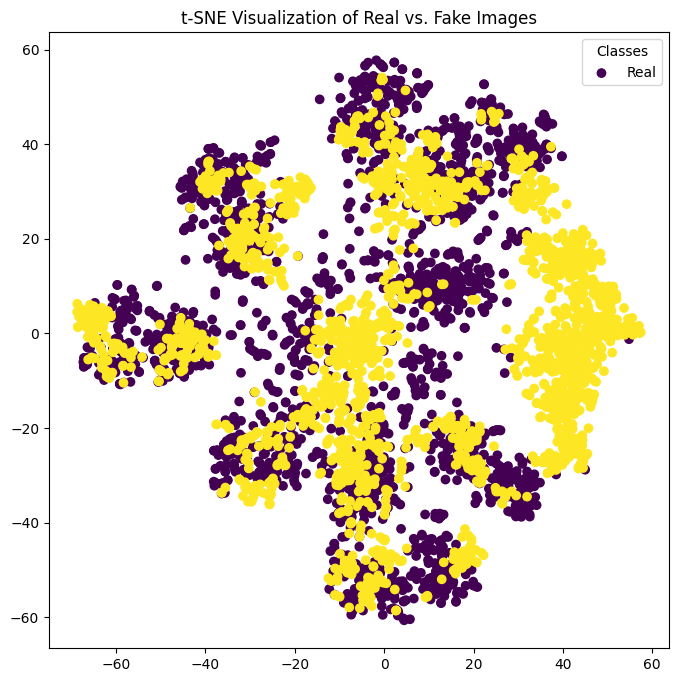

In [30]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(train_features)

plt.figure(figsize=(8, 8))
scatter = plt.scatter(embedded_features[:, 0], embedded_features[:, 1], c=train_labels, cmap='viridis')
plt.title('t-SNE Visualization of Real vs. Fake Images')
plt.legend(*scatter.legend_elements(), title='Classes', labels=['Real', 'Fake'])
plt.show()
